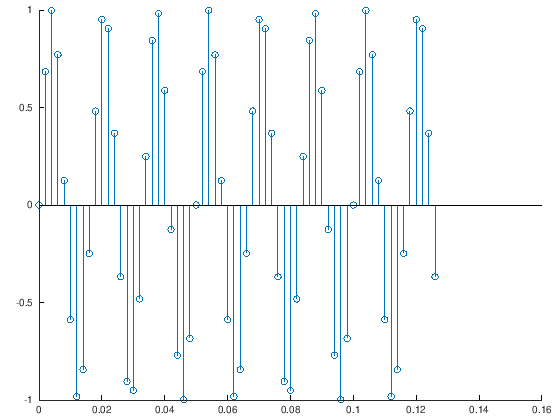

In [1]:
clear all; close all;
Fa=60;
N=64; k=1:N; k=k-1;
Fe=500; Te=1/Fe; t=k*Te;
Df=Fe/N; f=k*Df;
s=sin(2*pi*Fa*t);
stem(t,s)

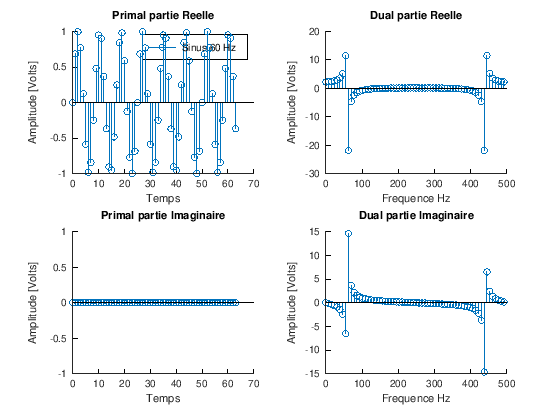

In [2]:
plot_dual(k,"Temps",
        s,"Amplitude [Volts]",
        f,"Frequence Hz",
        fft(s),"Amplitude [Volts]",
        ["Sinus 60 Hz"],
        primalDiscret=true,
        dualDiscret=true)
